In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# =============================================================================
# [Step 1] 데이터 로드 및 병합 (3개 파일)
# =============================================================================

# 파일 경로 (실제 경로에 맞게 수정)
path_approval = '../300K_wideformat/카드승인정보_WideFormat_50000_2569.csv'
path_balance = '../300K_wideformat/카드잔액정보_WideFormat_50000_487.csv'
path_VIPcode = '../300K_wideformat/카드회원정보_WideFormat_50000_463.csv'
# 분석 대상 월 설정
months_6m = ['07', '08', '09', '10', '11', '12'] # 기울기용 (6개월)
months_3m = ['10', '11', '12']                  # 상태점수용 (최근 3개월)

# ---------------------------------------------------------
# 1. 카드승인정보 로드 (소비, 빈도)
# ---------------------------------------------------------
cols_approval = ['발급회원번호']
for m in months_6m:
    cols_approval.append(f'이용금액_신용_B0M_{m}')  # 소비 기울기
    cols_approval.append(f'이용건수_신용_B0M_{m}')  # 빈도 기울기 & 활동성 점수

print("1. 승인정보 로드 중...")
df_approval = pd.read_csv(path_approval, usecols=lambda x: x in cols_approval)
df_approval.fillna(0, inplace=True)

# ---------------------------------------------------------
# 2. 카드잔액정보 로드 (부채, 연체, 자산)
# ---------------------------------------------------------
cols_balance = ['발급회원번호']
for m in months_6m:
    cols_balance.append(f'잔액_B0M_{m}')             # 잔액 기울기
    cols_balance.append(f'잔액_현금서비스_B0M_{m}')  # 악성부채
    cols_balance.append(f'잔액_카드론_B0M_{m}')      # 악성부채
    cols_balance.append(f'연체잔액_B0M_{m}')         # 연체점수
    # 평잔 컬럼 (월중평잔_12 또는 월중평잔_B0M_12 유연하게 대응)
    cols_balance.append(f'월중평잔_{m}') 

print("2. 잔액정보 로드 중...")
try:
    df_balance = pd.read_csv(path_balance, usecols=lambda x: x in cols_balance)
except ValueError:
    print("   ⚠️ 컬럼명 불일치로 전체 로드 후 필터링합니다.")
    df_balance = pd.read_csv(path_balance)
    # 존재하는 컬럼만 남기기
    exist_cols = [c for c in cols_balance if c in df_balance.columns]
    df_balance = df_balance[exist_cols]

df_balance.fillna(0, inplace=True)

# 2-1 VIP등급 코드 포함

# ---------------------------------------------------------
# 3. 데이터 병합
# ---------------------------------------------------------
print("3. 데이터 병합 중...")
df = pd.merge(df_approval, df_balance, on='발급회원번호', how='inner')
print(f"   병합 완료 Shape: {df.shape}")


# =============================================================================
# [Step 2] (A) 상태 기반 점수 (Status Score) 산출
# =============================================================================

# 1. [부정] 악성 부채 점수 (현금서비스/카드론 잔액 급증)
# (12월 - 11월) / (11월 + 1) -> 급증 시 점수 상승
df['Score_BadDebt'] = (
    ((df['잔액_현금서비스_B0M_12'] - df['잔액_현금서비스_B0M_11']) / (df['잔액_현금서비스_B0M_11'] + 1) * 1.5) +
    ((df['잔액_카드론_B0M_12'] - df['잔액_카드론_B0M_11']) / (df['잔액_카드론_B0M_11'] + 1) * 1.0)
)

# 2. [부정] 연체 강도 점수 (최근 연체일수록 가중치)
df['Score_Delinq'] = (
    (df['연체잔액_B0M_12'] * 3.0) +
    (df['연체잔액_B0M_11'] * 2.0) +
    (df['연체잔액_B0M_10'] * 1.0)
)

# 3. [긍정] 활동성 점수 (이용건수 활용)
cols_cnt_r3 = [f'이용건수_신용_B0M_{m}' for m in ['10', '11', '12']]
cols_cnt_r6 = [f'이용건수_신용_B0M_{m}' for m in months_6m]

sum_r3 = df[cols_cnt_r3].sum(axis=1)
sum_r6 = df[cols_cnt_r6].sum(axis=1)
# ((최근3개월*2) - 6개월합) -> 양수면 최근 활발 -> 점수 높음(긍정)
df['Score_Activity'] = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100

# 4. [긍정] 자산 방어 점수 (월중평잔 활용)
# 컬럼명 확인 ('월중평잔_12' 우선, 없으면 '월중평잔_B0M_12')
bal_prefix = '월중평잔'
if f'{bal_prefix}_12' not in df.columns:
    bal_prefix = '월중평잔_B0M'

cols_avg_r3 = [f'{bal_prefix}_{m}' for m in ['10', '11', '12'] if f'{bal_prefix}_{m}' in df.columns]
cols_avg_r6 = [f'{bal_prefix}_{m}' for m in months_6m if f'{bal_prefix}_{m}' in df.columns]

if cols_avg_r3:
    avg_r3 = df[cols_avg_r3].mean(axis=1)
    avg_r6 = df[cols_avg_r6].mean(axis=1)
    df['Score_Asset'] = (avg_r3 / (avg_r6 + 1)) * 10
else:
    df['Score_Asset'] = 0

# >> (A) 상태 종합 점수 (부정 - 긍정)
df['Score_Status_Total'] = (df['Score_BadDebt'] + df['Score_Delinq']) - (df['Score_Activity'] + df['Score_Asset'])


# =============================================================================
# [Step 3] (B) 기울기 기반 점수 (Slope Score) 산출
# =============================================================================

# 기울기 계산 함수
def calc_slope(row, col_prefix):
    cols = [f"{col_prefix}_{m}" for m in months_6m]
    # 실제 존재하는 컬럼만 필터링
    valid_cols = [c for c in cols if c in row.index]
    
    if len(valid_cols) < 2: return 0
    y = row[valid_cols].values.astype(float)
    if np.sum(y) == 0: return 0
    
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

print("4. 기울기 산출 중... (시간이 소요될 수 있습니다)")

# 1. 지표별 기울기 계산
df['Slope_Spend'] = df.apply(lambda row: calc_slope(row, '이용금액_신용_B0M'), axis=1)
df['Slope_Balance'] = df.apply(lambda row: calc_slope(row, '잔액_B0M'), axis=1)
df['Slope_Count'] = df.apply(lambda row: calc_slope(row, '이용건수_신용_B0M'), axis=1)

# 2. 정규화 및 무한대 처리
scaler = MinMaxScaler()

def normalize_risk(series):
    # 무한대값 제거
    series = series.replace([np.inf, -np.inf], 0).fillna(0)
    # 음수(감소)만 위험 점수로 변환 (양수로 변경), 증가는 0점
    risk = series.apply(lambda x: -x if x < 0 else 0)
    return scaler.fit_transform(risk.values.reshape(-1, 1)).flatten()

df['Norm_Slope_Spend'] = normalize_risk(df['Slope_Spend'])
df['Norm_Slope_Balance'] = normalize_risk(df['Slope_Balance'])
df['Norm_Slope_Count'] = normalize_risk(df['Slope_Count'])

# 3. (B) 기울기 종합 점수 (가중치: 소비40, 잔액30, 건수30)
df['Score_Slope_Total'] = (
    (df['Norm_Slope_Spend'] * 40) +
    (df['Norm_Slope_Balance'] * 30) +
    (df['Norm_Slope_Count'] * 30)
)


# =============================================================================
# [Step 4] 최종 통합 점수 산출
# =============================================================================

# 상태 점수 + 기울기 점수
# 무한대 값 한번 더 안전하게 0 처리 후 합산
df['Score_Status_Total'] = df['Score_Status_Total'].replace([np.inf, -np.inf], 0).fillna(0)
df['Score_Slope_Total'] = df['Score_Slope_Total'].replace([np.inf, -np.inf], 0).fillna(0)

df['Final_Total_Score'] = (df['Score_Status_Total'] + df['Score_Slope_Total'])*0.5

print("\n✅ 최종 통합 점수 산출 완료!")
# 결과 확인 (상위 5개 행)
print(df[['발급회원번호', 'Final_Total_Score', 'Score_Status_Total', 'Score_Slope_Total']].head())

# 필요시 CSV 저장
# df.to_csv('Final_Churn_Score_Result.csv', index=False, encoding='utf-8-sig')

1. 승인정보 로드 중...
2. 잔액정보 로드 중...
3. 데이터 병합 중...
   병합 완료 Shape: (50000, 43)
4. 기울기 산출 중... (시간이 소요될 수 있습니다)

✅ 최종 통합 점수 산출 완료!
        발급회원번호  Final_Total_Score  Score_Status_Total  Score_Slope_Total
0  SYN_1000048         -10.674369          -21.348738           0.000000
1  SYN_1000194         -26.496139          -57.219573           4.227296
2  SYN_1000201          17.561960           26.484019           8.639900
3   SYN_100022          -8.561691          -17.123381           0.000000
4  SYN_1000250           1.464746            0.000000           2.929491


In [2]:
df['Final_Total_Score'].value_counts(normalize=True)

Final_Total_Score
 0.000000      0.01888
 100.000000    0.00488
 25.000000     0.00362
-25.000000     0.00298
 12.500000     0.00282
                ...   
 5.314810      0.00002
 5.182280      0.00002
-6.486152      0.00002
-5.740755      0.00002
-8.578374      0.00002
Name: proportion, Length: 41377, dtype: float64

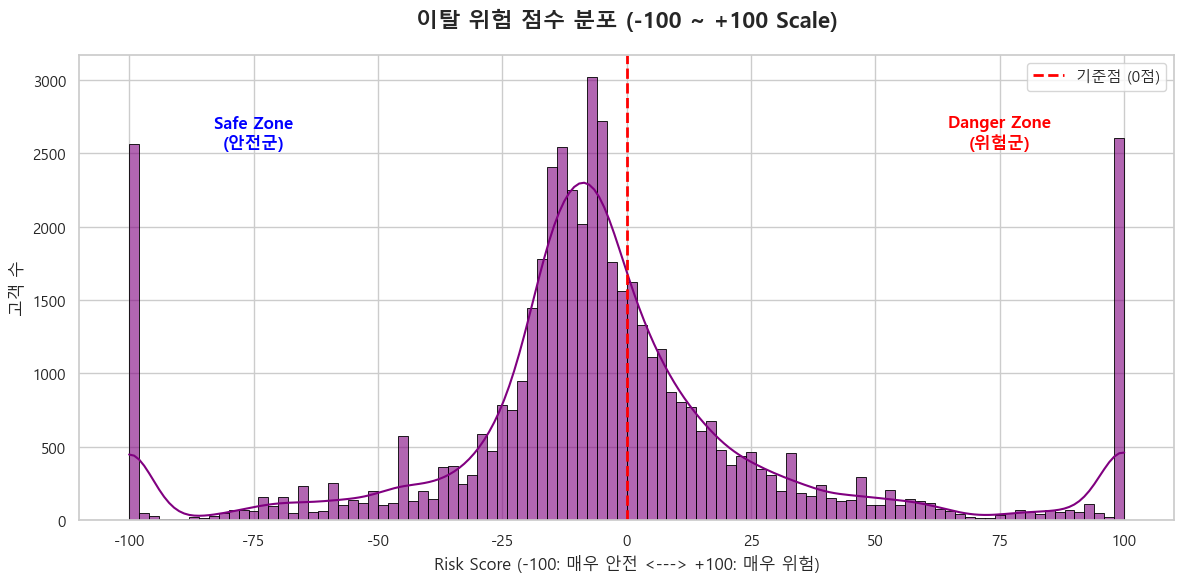

=== 점수 통계 요약 ===
count    50000.000000
mean        -4.070235
std         40.727969
min       -100.000000
25%        -17.574686
50%         -6.142608
75%          8.120711
max        100.000000
Name: Risk_Score_Centered, dtype: float64


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 가정: df 데이터프레임에 'Final_Total_Score'가 계산되어 있음
# =========================================================

# [Step 1] 이상치 제어 (Clipping) - 필수 과정
# 설명: 극단적인 값(상/하위 1~5%)을 잘라내지 않으면, 스케일링해도 중앙에 다 몰립니다.
lower_limit = df['Final_Total_Score'].quantile(0.05) # 하위 5%
upper_limit = df['Final_Total_Score'].quantile(0.95) # 상위 5%

df['Score_Clipped'] = df['Final_Total_Score'].clip(lower_limit, upper_limit)

# [Step 2] 점수 변환 (Min-Max Scaling -> -100 ~ +100점)
# 설명: 가장 안전한 사람을 -100점, 가장 위험한 사람을 +100점으로 맞춥니다.
scaler = MinMaxScaler(feature_range=(-100, 100))
df['Risk_Score_Centered'] = scaler.fit_transform(df[['Score_Clipped']])

# [Step 3] 시각화 및 검증
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
sns.histplot(df['Risk_Score_Centered'], bins=100, kde=True, color='purple', edgecolor='black', alpha=0.6)

# 기준선(0점) 표시
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='기준점 (0점)')

# 구간 의미 표시 (텍스트)
plt.text(-75, plt.ylim()[1]*0.8, 'Safe Zone\n(안전군)', fontsize=12, color='blue', ha='center', fontweight='bold')
plt.text(75, plt.ylim()[1]*0.8, 'Danger Zone\n(위험군)', fontsize=12, color='red', ha='center', fontweight='bold')

plt.title('이탈 위험 점수 분포 (-100 ~ +100 Scale)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Risk Score (-100: 매우 안전 <---> +100: 매우 위험)')
plt.ylabel('고객 수')
plt.legend()
plt.tight_layout()
plt.show()

# [Step 4] 결과 확인
print("=== 점수 통계 요약 ===")
print(df['Risk_Score_Centered'].describe())

📉 제거되는 최저점(-100) 고객 수: 2505명
📈 제거되는 최고점(+100) 고객 수: 2514명


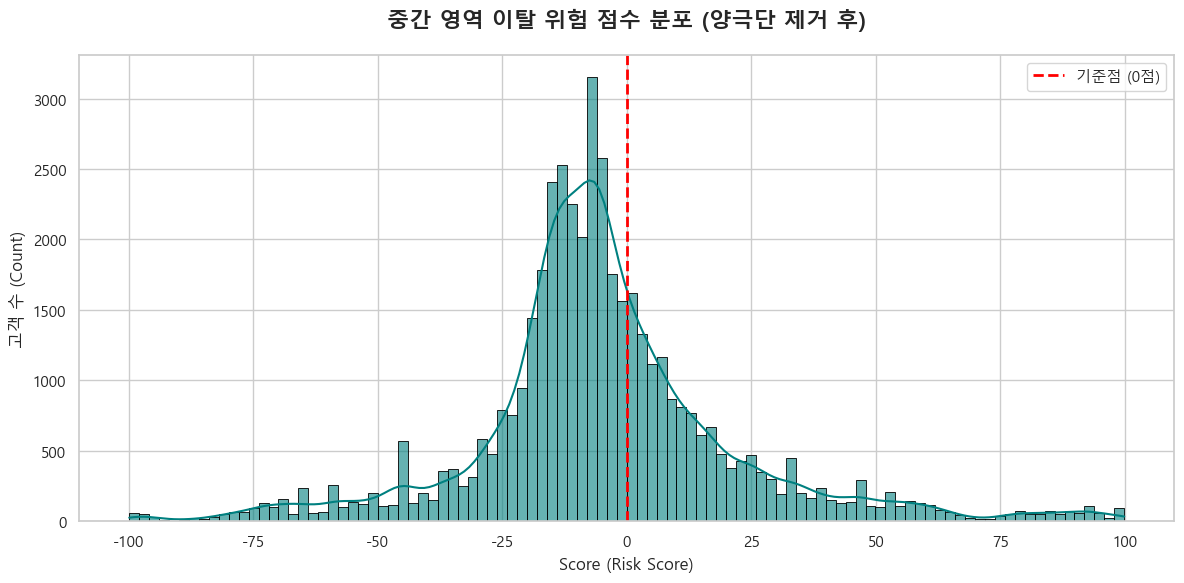


=== 필터링 후 점수 통계 요약 ===
count    44981.000000
mean        -4.544394
std         26.940561
min        -99.880097
25%        -16.123733
50%         -6.143532
75%          5.916886
max         99.878272
Name: Risk_Score_Centered, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 가정: df에 'Risk_Score_Full_Range' (또는 사용 중인 점수 컬럼)이 존재
# 컬럼명이 다르다면 아래 변수를 수정하세요.
target_col = 'Risk_Score_Centered' 
# =========================================================

# 1. 양극단(-100, 100) 데이터 분리 (제거 전 확인용)
df_min_outlier = df[df[target_col] <= -99.9]
df_max_outlier = df[df[target_col] >= 99.9]

print(f"📉 제거되는 최저점(-100) 고객 수: {len(df_min_outlier)}명")
print(f"📈 제거되는 최고점(+100) 고객 수: {len(df_max_outlier)}명")

# 2. 양극단 제거 (가운데 분포만 남김)
# -99.9점 초과 ~ 99.9점 미만인 데이터만 필터링
df_filtered = df[(df[target_col] > -99.9) & (df[target_col] < 99.9)]

# 3. 분포 재시각화
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid", font="Malgun Gothic")

# 히스토그램 (양극단 제거 후)
sns.histplot(df_filtered[target_col], bins=100, kde=True, color='teal', edgecolor='black', alpha=0.6)

# 0점 기준선
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='기준점 (0점)')

plt.title(f'중간 영역 이탈 위험 점수 분포 (양극단 제거 후)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Score (Risk Score)')
plt.ylabel('고객 수 (Count)')
plt.legend()

plt.tight_layout()
plt.show()

# 4. 필터링된 데이터의 통계 확인
print("\n=== 필터링 후 점수 통계 요약 ===")
print(df_filtered[target_col].describe())

In [ ]:
# df.to_csv('Final_Total_Score_WideFormat_50000_2569.csv', index=False)